In [1]:
# preprocessing
# imports & paths
import os, re, shutil
from sklearn.model_selection import train_test_split

# Path to existing per-crop train_set + test_set root
RAW_DIR = "/kaggle/input/crop-pest-and-disease-dataset/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented"

# Where I’ll build our unified folders
OUT_DIR = "/kaggle/working/CCMT_unified"
TRAIN_DIR = os.path.join(OUT_DIR, "train")
TEST_DIR  = os.path.join(OUT_DIR, "test")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

In [2]:
# define the 18 clean categories
CATEGORIES = [
    "anthracnose", "gummosis", "leaf miner", "red rust",
    "bacterial blight", "brown spot", "green mite", "mosaic",
    "fall armyworm", "grasshopper", "leaf beetle", "leaf blight",
    "leaf spot", "streak virus", "leaf curl", "septoria leaf spot",
    "verticillium wilt", "healthy"
]

# Pre-create subfolders
for cat in CATEGORIES:
    os.makedirs(os.path.join(TRAIN_DIR, cat), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR,  cat), exist_ok=True)

In [3]:
# helper to clean folder names
def clean_name(name):
    """
    Strip trailing digits/spaces, collapse multiple spaces, lower-case.
    e.g. 'leaf miner3466 ' -> 'leaf miner'
    """
    # remove digits
    no_digits = re.sub(r"\d+", "", name)
    # tidy spaces
    neat = re.sub(r"\s+", " ", no_digits).strip().lower()
    return neat

In [4]:
# gather all image paths with their cleaned labels
all_images = []  # list of (src_path, label)
for crop in os.listdir(RAW_DIR):
    crop_dir = os.path.join(RAW_DIR, crop)
    if not os.path.isdir(crop_dir): 
        continue
    # look into both train_set and test_set folders
    for subset in ("train_set", "test_set"):
        subset_dir = os.path.join(crop_dir, subset)
        if not os.path.isdir(subset_dir):
            continue
        # iterate each (possibly numeric-suffixed) class folder
        for fld in os.listdir(subset_dir):
            fld_path = os.path.join(subset_dir, fld)
            if not os.path.isdir(fld_path):
                continue
            lbl = clean_name(fld)
            if lbl not in CATEGORIES:
                # skip any unexpected folders
                continue
            # pick up all jpg/png/etc.
            for fname in os.listdir(fld_path):
                if fname.lower().endswith((".jpg",".jpeg",".png")):
                    all_images.append((os.path.join(fld_path, fname), lbl))

print(f"Found {len(all_images)} total images across {len(CATEGORIES)} categories")


Found 96263 total images across 18 categories


In [5]:
# split into train/test and copy files
# stratify by label to keep class balance
paths, labels = zip(*all_images)
train_paths, test_paths, train_lbls, test_lbls = train_test_split(
    paths, labels,
    test_size=0.20,
    random_state=42,
    stratify=labels
)

def copy_subset(paths, labels, dest_root):
    for src, lbl in zip(paths, labels):
        dest = os.path.join(dest_root, lbl, os.path.basename(src))
        shutil.copy(src, dest)

# execute copy
copy_subset(train_paths, train_lbls, TRAIN_DIR)
copy_subset(test_paths, test_lbls,  TEST_DIR)

print(f"  • Training images: {len(train_paths)}")
print(f"  •   Testing images: {len(test_paths)}")

  • Training images: 77010
  •   Testing images: 19253


In [6]:
# Imports, paths, and hyperparameters

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Paths to unified folders
TRAIN_DIR = "/kaggle/working/CCMT_unified/train"
TEST_DIR  = "/kaggle/working/CCMT_unified/test"

# Image + training parameters
IMG_SIZE        = (224, 224)
BATCH_SIZE      = 16
INITIAL_EPOCHS  = 10
FINETUNE_EPOCHS = 20
TOTAL_EPOCHS    = INITIAL_EPOCHS + FINETUNE_EPOCHS

# Dynamically infer number of classes (should be 18)
NUM_CLASSES = len(next(os.walk(TRAIN_DIR))[1])
print(f"Detected {NUM_CLASSES} classes in {TRAIN_DIR}")


2025-05-01 23:18:57.701569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746141537.901363      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746141537.957790      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Detected 18 classes in /kaggle/working/CCMT_unified/train


In [7]:
# Build tf.data pipelines with shuffle, prefetch, augmentation, and preprocessing

# a) Load raw datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# b) Prefetch only (no in-RAM cache to avoid OOM)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

# c) **Real data-augmentation layers** — list each one explicitly
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# d) Preprocessing fn for ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# e) Combined prepare function
def prepare(ds, training=False):
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float32), y),
        num_parallel_calls=AUTOTUNE
    )
    if training:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )
    ds = ds.map(
        lambda x, y: (preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE
    )
    return ds

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)

Found 77010 files belonging to 18 classes.


I0000 00:00:1746141554.068797      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746141554.069546      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 19253 files belonging to 18 classes.


In [8]:
# Build & compile ResNet50-based model

def build_model():
    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    base_model.trainable = False

    inputs  = tf.keras.Input(shape=IMG_SIZE + (3,))
    x       = data_augmentation(inputs)
    x       = preprocess_input(x)
    x       = base_model(x, training=False)
    x       = tf.keras.layers.GlobalAveragePooling2D()(x)
    x       = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 18)             │         36,882 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,624,594 (90.12 MB)

 Trainable params: 36,882 (144.07 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Callbacks & learning-rate schedule (save weights only)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="resnet50_head.weights.h5",  
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
callbacks = [checkpoint, reduce_lr, early_stop]


In [10]:
# Train the new classification head

history_head = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/10


I0000 00:00:1746141598.779317      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5689 - loss: 1.3103
Epoch 1: val_accuracy improved from -inf to 0.69776, saving model to resnet50_head.weights.h5
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 685s 134ms/step - accuracy: 0.5689 - loss: 1.3103 - val_accuracy: 0.6978 - val_loss: 0.9460 - learning_rate: 0.0010
Epoch 2/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6594 - loss: 1.0267
Epoch 2: val_accuracy did not improve from 0.69776
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 664s 134ms/step - accuracy: 0.6594 - loss: 1.0267 - val_accuracy: 0.6971 - val_loss: 0.9853 - learning_rate: 0.0010
Epoch 3/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6670 - loss: 1.0263
Epoch 3: val_accuracy did not improve from 0.69776

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 670s 136ms/step - accuracy: 0.6670 - loss: 1.0263 - val_accuracy: 0.6583 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 4/10
4814/4814 ━━━━━━

In [11]:
# Fine-tune deeper layers

# 1) Load best head weights
model.load_weights("resnet50_head.weights.h5")

# 2) Locate the ResNet50 submodel
#    (Uncomment the print loop once to confirm the name/index, then pick the right one.)
# for i,layer in enumerate(model.layers):
#     print(i, layer.name, type(layer))

# Here we assume the submodel is named "resnet50"
base_model = model.get_layer("resnet50")  
base_model.trainable = True

# 3) Find the start of conv5_block1 (first layer of last block)
start_fine_tune = next(
    (i for i, l in enumerate(base_model.layers) if l.name == "conv5_block1_out"),
    len(base_model.layers)//2
)

# 4) Freeze all layers up to that point, unfreeze the rest
for layer in base_model.layers[:start_fine_tune]:
    layer.trainable = False
for layer in base_model.layers[start_fine_tune:]:
    layer.trainable = True

# 5) Recompile with a lower LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 6) Continue training
history_fine = model.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_head.epoch[-1],
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 10/30
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7366 - loss: 0.7387
Epoch 10: val_accuracy improved from 0.72976 to 0.79234, saving model to resnet50_head.weights.h5
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 713s 141ms/step - accuracy: 0.7366 - loss: 0.7387 - val_accuracy: 0.7923 - val_loss: 0.6089 - learning_rate: 1.0000e-04
Epoch 11/30
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8087 - loss: 0.5222
Epoch 11: val_accuracy improved from 0.79234 to 0.80050, saving model to resnet50_head.weights.h5
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 711s 144ms/step - accuracy: 0.8087 - loss: 0.5222 - val_accuracy: 0.8005 - val_loss: 0.6115 - learning_rate: 1.0000e-04
Epoch 12/30
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8362 - loss: 0.4443
Epoch 12: val_accuracy improved from 0.80050 to 0.81977, saving model to resnet50_head.weights.h5
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 696s 141ms/step - accuracy: 0.8362 - loss: 0.4442 - val_accuracy: 0.8198 - val_loss: 0.5525 - learni

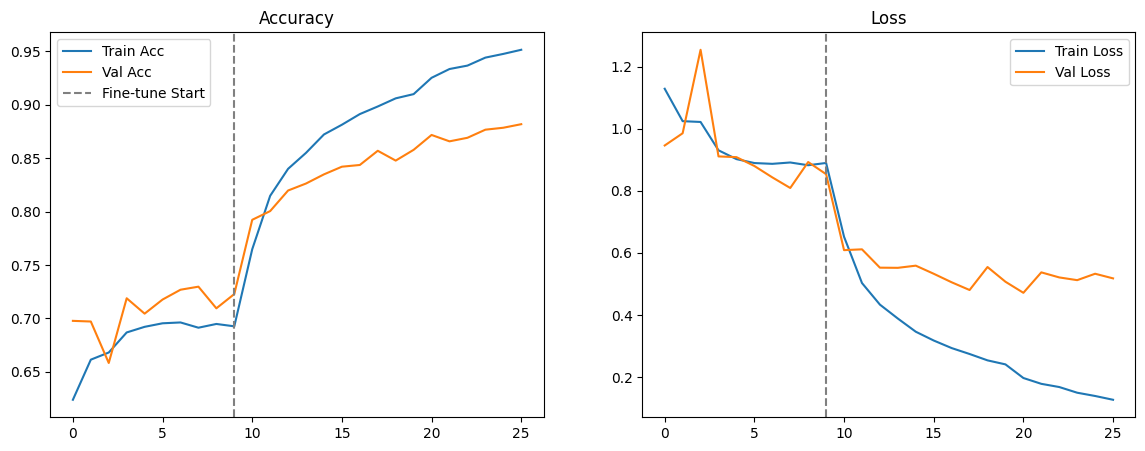

In [12]:
# Plot combined training history

def plot_history(h1, h2):
    acc      = h1.history["accuracy"] + h2.history["accuracy"]
    val_acc  = h1.history["val_accuracy"] + h2.history["val_accuracy"]
    loss     = h1.history["loss"] + h2.history["loss"]
    val_loss = h1.history["val_loss"] + h2.history["val_loss"]
    epochs   = range(len(acc))

    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc,     label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.axvline(INITIAL_EPOCHS-1, linestyle="--", color="gray", label="Fine-tune Start")
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss,     label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.axvline(INITIAL_EPOCHS-1, linestyle="--", color="gray")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history_head, history_fine)


In [13]:
# Save final model weights

model.save_weights("resnet50_final.weights.h5")
print("Final weights saved to resnet50_final.weights.h5")


Final weights saved to resnet50_final.weights.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


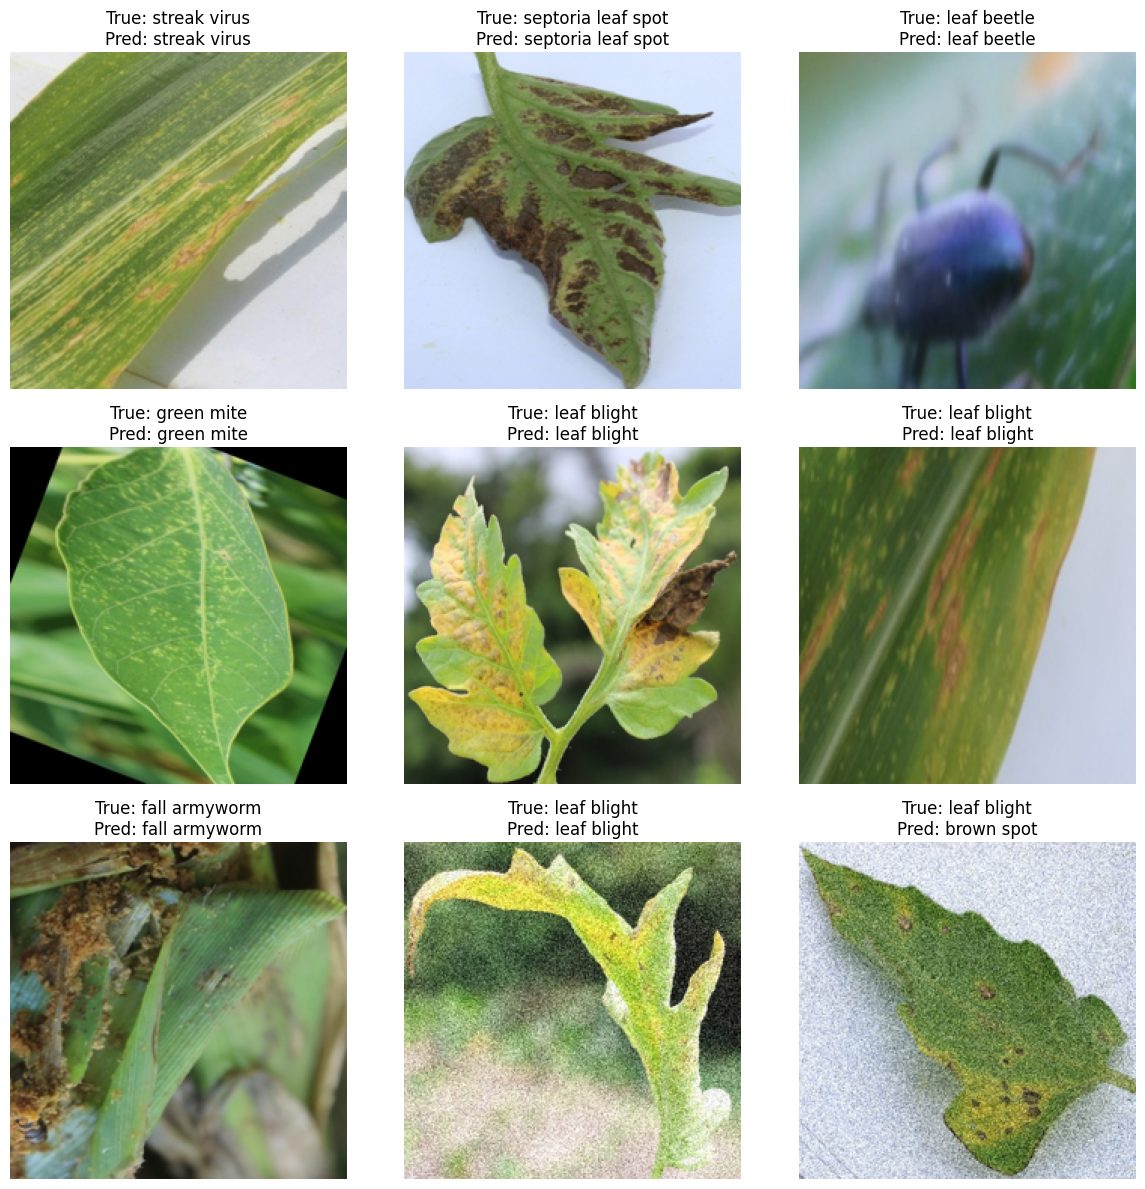

In [14]:
# Sample‐based visualization from any image format

import pathlib
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# a) Gather all files under TEST_DIR (any extension)
all_files = list(pathlib.Path(TEST_DIR).rglob("*"))
image_files = [p for p in all_files if p.is_file()]

# b) Sample 9 (or fewer) images
sample_paths = random.sample(image_files, min(9, len(image_files)))

# c) Load & prepare images and true labels
imgs, true_labels = [], []
for p in sample_paths:
    img = Image.open(p).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img)
    imgs.append(arr)
    true_labels.append(p.parent.name)  # folder name is the true label

imgs = np.stack(imgs)  # shape (9, H, W, 3)
imgs_pre = preprocess_input(imgs.astype(np.float32))

# d) Predict
pred_probs   = model.predict(imgs_pre)
pred_indices = np.argmax(pred_probs, axis=1)

# e) Compute class_names automatically (alphabetical, as used by Keras)
class_names = sorted([d.name for d in pathlib.Path(TRAIN_DIR).iterdir() if d.is_dir()])

# f) Plot 3×3 grid
plt.figure(figsize=(12,12))
for i, orig in enumerate(imgs):
    plt.subplot(3, 3, i+1)
    plt.imshow(orig.astype("uint8"))
    plt.title(
        f"True: {true_labels[i]}\n"
        f"Pred: {class_names[pred_indices[i]]}"
    )
    plt.axis("off")
plt.tight_layout()
plt.show()


1204/1204 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step


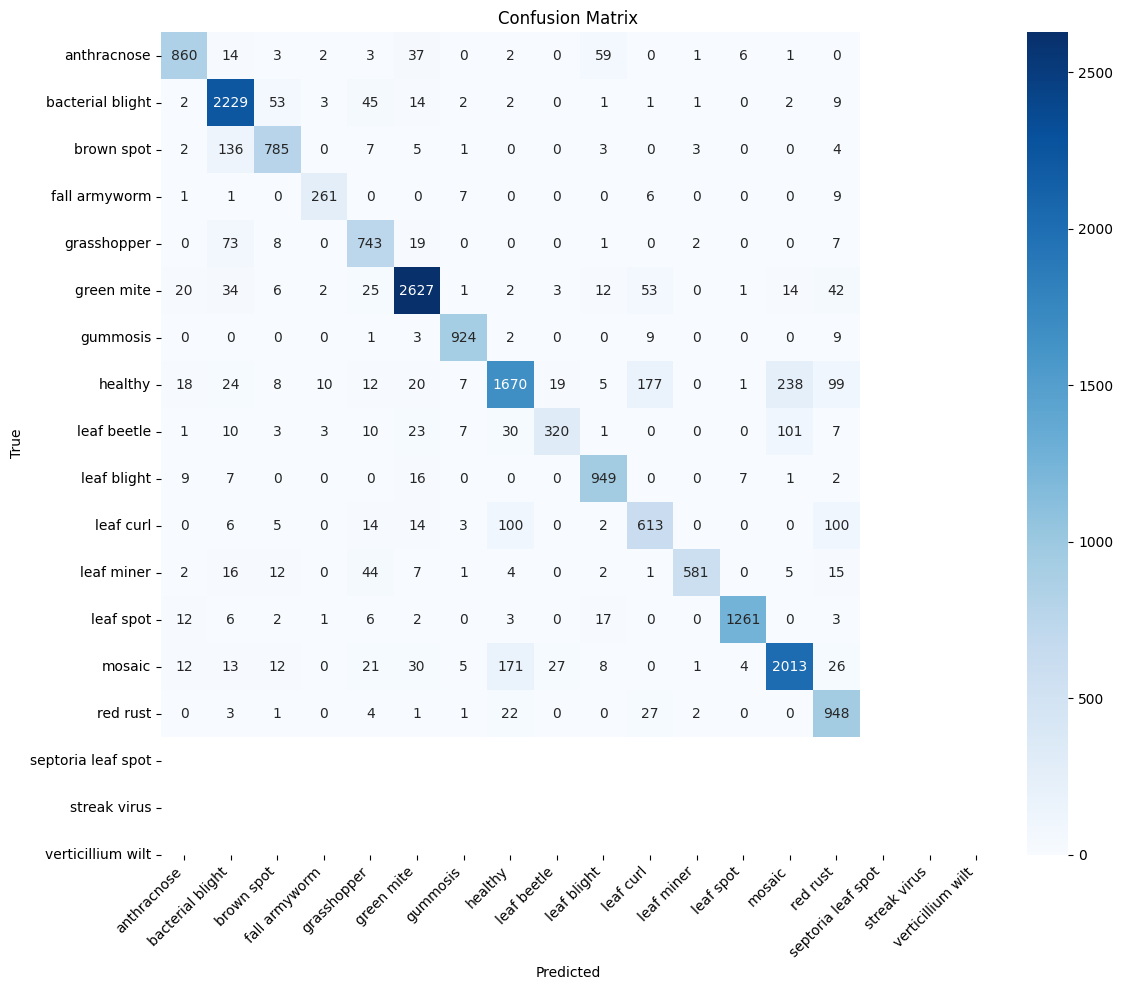

In [15]:
# Confusion Matrix for Validation Set

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pathlib

# a) Automatically get class names (alphabetical order as used by the model)
class_names = sorted([d.name for d in pathlib.Path(TRAIN_DIR).iterdir() if d.is_dir()])

# b) Predict on the entire validation dataset
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# c) Extract true labels from val_ds
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# d) Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
